In [2]:
import scanpy as sc
from scipy.sparse import csc_matrix, csr_matrix, save_npz
from scipy.io import mmread, mmwrite
import numpy as np
import pandas as pd
from pathlib import Path
from os import path
import seaborn as sns

In [280]:
h5_file = '/gpfs/gibbs/pi/zhao/yw599/Multiome/data/BMMC/BMMC_processed_s3d7.h5ad'
frag_file = '/gpfs/gibbs/pi/zhao/yw599/Multiome/data/BMMC/post_competition/multiome/s3d7/atac_fragments.tsv.gz'
frag_ind_file = '/gpfs/gibbs/pi/zhao/yw599/Multiome/data/BMMC/post_competition/multiome/s3d7/atac_fragments.tsv.gz.tbi'
data = scanpy.read_h5ad(h5_file)

In [3]:
data = sc.read_h5ad('data/BMMC/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')

In [4]:
data

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [5]:
is_gex_col = data.var.feature_types == 'GEX'

In [6]:
adata_rna = data[:, is_gex_col]
adata_rna.X = adata_rna.layers['counts']
del adata_rna.layers['counts']

In [7]:
adata_ga = sc.AnnData(data.obsm['ATAC_gene_activity'], obs = data.obs) # ga: gene activity
adata_ga.obs_names = data.obs_names
adata_ga.var_names = data.uns['ATAC_gene_activity_var_names']

In [8]:
adata_ga.X.max(1).todense()

matrix([[2.5858066],
        [2.4006023],
        [2.5382473],
        ...,
        [2.3615377],
        [2.3193169],
        [2.5638733]], dtype=float32)

In [9]:
def simMatrix(adata, normalize=True, log=True, hvgs=2000, npcs=30, cell_type='annotation'):
    if normalize:
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    if log:
        sc.pp.log1p(adata)
    if hvgs:
        sc.pp.highly_variable_genes(adata, n_top_genes=hvgs)
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=True)
    sc.pp.neighbors(adata, n_pcs=npcs)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=[cell_type], legend_loc='on data')
    sc.tl.paga(adata, groups=cell_type)
    sc.pl.paga(adata, color=[cell_type])
    pos = adata.uns['paga']['pos']
    D = np.zeros((pos.shape[0], pos.shape[0]))
    for i in range(D.shape[0]-1):
        for j in range(i+1,D.shape[0]):
            D[i,j] = (((pos[i,]-pos[j,])**2).sum())**.5
    D = D+D.transpose()
    ct = adata.obs[cell_type].cat.categories.tolist()
    sim = pd.DataFrame(np.exp(-D), index=ct, columns=ct)
    return sim

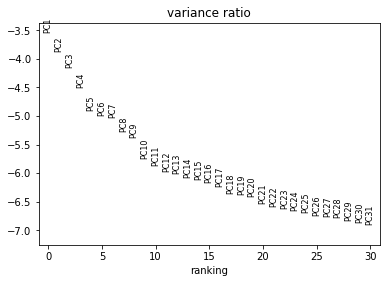

2022-07-20 22:19:51.466835: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ysm-gpfs/apps/software/GCCcore/10.2.0/lib64:/ysm-gpfs/apps/software/GCCcore/10.2.0/lib:/ysm-gpfs/apps/software/R/4.0.3-foss-2020b/lib64/R/lib:/ysm-gpfs/apps/software/R/4.0.3-foss-2020b/lib64:/ysm-gpfs/apps/software/nodejs/12.19.0-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/GLPK/4.65-GCCcore-10.2.0/lib:/gpfs/ysm/apps/software/ImageMagick/7.0.10-35-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/LittleCMS/2.11-GCCcore-10.2.0/lib:/gpfs/ysm/apps/software/JasPer/2.0.26-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/Ghostscript/9.53.3-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/Armadillo/10.2.1-foss-2020b/lib64:/ysm-gpfs/apps/software/arpack-ng/3.8.0-foss-2020b/lib:/ysm-gpfs/apps/software/Boost/1.74.0-GCCcore-10.2.0/lib:/ysm-gpfs/apps/software/GSL/2.6-GCCcor

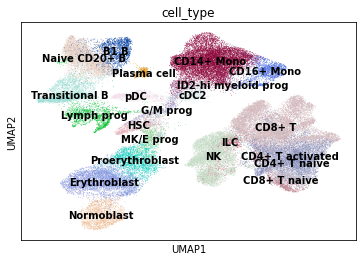

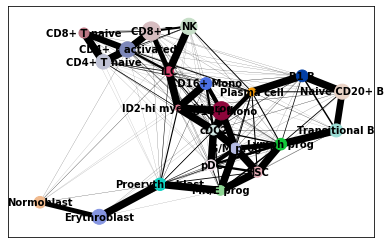

In [10]:
sim_rna = simMatrix(adata_rna, cell_type='cell_type')

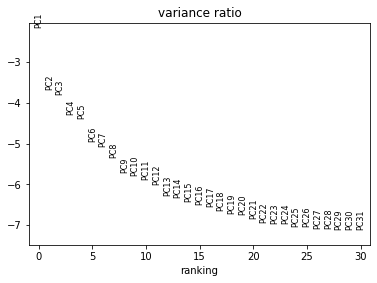

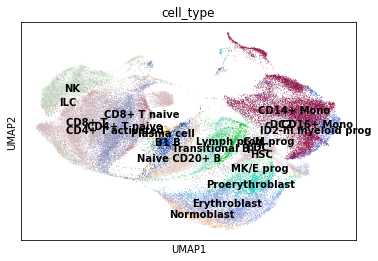

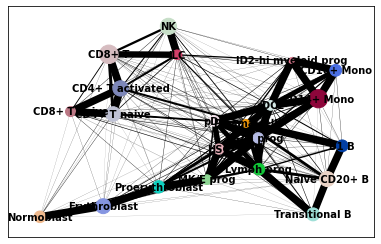

In [11]:
sim_atac = simMatrix(adata_ga, normalize=False, log=False, cell_type='cell_type')

In [12]:
sim_rna

B1 B  CD4+ T activated  CD4+ T naive    CD8+ T  \
B1 B                 1.000000          0.027602      0.017738  0.038600   
CD4+ T activated     0.027602          1.000000      0.559627  0.511389   
CD4+ T naive         0.017738          0.559627      1.000000  0.288126   
CD8+ T               0.038600          0.511389      0.288126  1.000000   
CD8+ T naive         0.010675          0.376897      0.435349  0.256888   
CD14+ Mono           0.156112          0.085657      0.067607  0.083916   
CD16+ Mono           0.141930          0.164390      0.116918  0.176536   
Erythroblast         0.004290          0.013520      0.019175  0.007826   
G/M prog             0.101891          0.035767      0.031322  0.032128   
HSC                  0.073151          0.016928      0.015087  0.015226   
ID2-hi myeloid prog  0.071489          0.164594      0.147630  0.131058   
ILC                  0.067609          0.365753      0.259900  0.336028   
Lymph prog           0.166325          0.019731      0.015670  0.020366   
MK/E prog            0.034839          0.017363      0.017516  0.013614   
NK                   0.073380          0.253311      0.142196  0.462786   
Naive CD20+ B        0.404805          0.011480      0.007557  0.015686   
Normoblast           0.002029          0.013878      0.022281  0.007379   
Plasma cell          0.334224          0.065059      0.045224  0.077686   
Proerythroblast      0.018578          0.030264      0.035902  0.020049   
Transitional B       0.211669          0.009166      0.006610  0.010960   
cDC2                 0.104137          0.067761      0.059099  0.059491   
pDC                  0.053612          0.033550      0.032824  0.026698   

                     CD8+ T naive  CD14+ Mono  CD16+ Mono  Erythroblast  \
B1 B                     0.010675    0.156112    0.141930      0.004290   
CD4+ T activated         0.376897    0.085657    0.164390      0.013520   
CD4+ T naive             0.435349    0.067607    0.116918      0.019175   
CD8+ T                   0.256888    0.083916    0.176536      0.007826   
CD8+ T naive             1.000000    0.032946    0.062013      0.009116   
CD14+ Mono               0.032946    1.000000    0.466403      0.025697   
CD16+ Mono               0.062013    0.466403    1.000000      0.017862   
Erythroblast             0.009116    0.025697    0.017862      1.000000   
G/M prog                 0.014353    0.369239    0.172877      0.038311   
HSC                      0.006847    0.178628    0.083315      0.033663   
ID2-hi myeloid prog      0.067615    0.414123    0.431187      0.040782   
ILC                      0.138562    0.232327    0.445269      0.019013   
Lymph prog               0.007571    0.229802    0.114982      0.016405   
MK/E prog                0.007674    0.131101    0.064401      0.079050   
NK                       0.119326    0.105289    0.223680      0.005610   
Naive CD20+ B            0.004400    0.083150    0.063303      0.002868   
Normoblast               0.012188    0.012962    0.010908      0.285407   
Plasma cell              0.024536    0.458617    0.386653      0.011888   
Proerythroblast          0.015728    0.105636    0.065098      0.227232   
Transitional B           0.003455    0.093402    0.055589      0.005149   
cDC2                     0.027205    0.595299    0.301491      0.040895   
pDC                      0.014486    0.246600    0.124670      0.073104   

                     G/M prog       HSC  ...  Lymph prog  MK/E prog        NK  \
B1 B                 0.101891  0.073151  ...    0.166325   0.034839  0.073380   
CD4+ T activated     0.035767  0.016928  ...    0.019731   0.017363  0.253311   
CD4+ T naive         0.031322  0.015087  ...    0.015670   0.017516  0.142196   
CD8+ T               0.032128  0.015226  ...    0.020366   0.013614  0.462786   
CD8+ T naive         0.014353  0.006847  ...    0.007571   0.007674  0.119326   
CD14+ Mono           0.369239  0.178628  ...    0.229802   0.131101  0.105289   
CD16+ 

In [13]:
sim_atac

B1 B  CD4+ T activated  CD4+ T naive    CD8+ T  \
B1 B                 1.000000          0.036875      0.039178  0.023093   
CD4+ T activated     0.036875          1.000000      0.575423  0.476159   
CD4+ T naive         0.039178          0.575423      1.000000  0.281158   
CD8+ T               0.023093          0.476159      0.281158  1.000000   
CD8+ T naive         0.021768          0.428231      0.553505  0.265465   
CD14+ Mono           0.349009          0.064192      0.057438  0.047430   
CD16+ Mono           0.200601          0.049675      0.040120  0.042533   
Erythroblast         0.028840          0.081051      0.140457  0.039702   
G/M prog             0.309033          0.113544      0.126253  0.065582   
HSC                  0.181374          0.153503      0.193711  0.080170   
ID2-hi myeloid prog  0.143323          0.087274      0.066135  0.079602   
ILC                  0.050146          0.346534      0.214918  0.388944   
Lymph prog           0.285162          0.076474      0.097081  0.040612   
MK/E prog            0.134851          0.102611      0.148881  0.050398   
NK                   0.030368          0.228882      0.133814  0.362146   
Naive CD20+ B        0.479668          0.031905      0.038174  0.018024   
Normoblast           0.011741          0.052560      0.090076  0.027872   
Plasma cell          0.242778          0.151653      0.157850  0.091010   
Proerythroblast      0.068209          0.115745      0.188150  0.055124   
Transitional B       0.220846          0.022936      0.030451  0.012033   
cDC2                 0.269504          0.121678      0.112558  0.083216   
pDC                  0.157527          0.230329      0.245310  0.131210   

                     CD8+ T naive  CD14+ Mono  CD16+ Mono  Erythroblast  \
B1 B                     0.021768    0.349009    0.200601      0.028840   
CD4+ T activated         0.428231    0.064192    0.049675      0.081051   
CD4+ T naive             0.553505    0.057438    0.040120      0.140457   
CD8+ T                   0.265465    0.047430    0.042533      0.039702   
CD8+ T naive             1.000000    0.032106    0.023014      0.127533   
CD14+ Mono               0.032106    1.000000    0.521876      0.023508   
CD16+ Mono               0.023014    0.521876    1.000000      0.013277   
Erythroblast             0.127533    0.023508    0.013277      1.000000   
G/M prog                 0.070301    0.308136    0.166461      0.075180   
HSC                      0.110701    0.175094    0.097643      0.134252   
ID2-hi myeloid prog      0.039041    0.409449    0.524040      0.017520   
ILC                      0.148911    0.114609    0.108659      0.034241   
Lymph prog               0.056224    0.181330    0.094975      0.101002   
MK/E prog                0.092835    0.099506    0.053584      0.213862   
NK                       0.104398    0.075681    0.082481      0.019772   
Naive CD20+ B            0.021782    0.181166    0.099121      0.042822   
Normoblast               0.102828    0.010094    0.005854      0.405069   
Plasma cell              0.087380    0.322505    0.186597      0.071152   
Proerythroblast          0.133992    0.055245    0.030703      0.419247   
Transitional B           0.018272    0.085746    0.046164      0.054559   
cDC2                     0.062722    0.508145    0.310090      0.042762   
pDC                      0.135789    0.219591    0.135921      0.093073   

                     G/M prog       HSC  ...  Lymph prog  MK/E prog        NK  \
B1 B                 0.309033  0.181374  ...    0.285162   0.134851  0.030368   
CD4+ T activated     0.113544  0.153503  ...    0.076474   0.102611  0.228882   
CD4+ T naive         0.126253  0.193711  ...    0.097081   0.148881  0.133814   
CD8+ T               0.065582  0.080170  ...    0.040612   0.050398  0.362146   
CD8+ T naive         0.070301  0.110701  ...    0.056224   0.092835  0.104398   
CD14+ Mono           0.308136  0.175094  ...    0.181330   0.099506  0.075681   
CD16+ 

<AxesSubplot:>

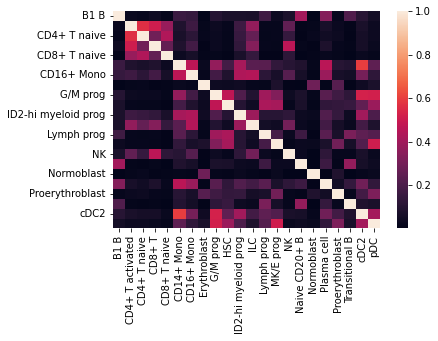

In [14]:
sns.heatmap(sim_rna)

<AxesSubplot:>

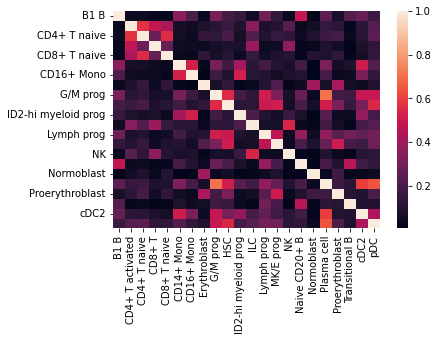

In [15]:
sns.heatmap(sim_atac)

In [16]:
def crossOmicSimMatrix(sim_rna, sim_atac):
    
    ct_rna = sim_rna.index.tolist()
    ct_atac = sim_atac.index.tolist()

    # common cell types
    ct_common = list(set(ct_rna).intersection(ct_atac))

    # rna unique cell types
    ct_rna_only = list(set(ct_rna).difference(ct_atac))

    # atac unique cell types
    ct_atac_only = list(set(ct_atac).difference(ct_rna))
    
    sim = np.zeros((len(ct_atac), len(ct_rna)))
    
    # common to common
    sim[:len(ct_common), :len(ct_common)] = (sim_rna.loc[ct_common, ct_common] + sim_atac.loc[ct_common, ct_common])/2
    
    # atac unique to common
    sim[len(ct_common):, :len(ct_common)] = sim_atac.loc[ct_atac_only, ct_common]
    
    # common to rna unique
    sim[:len(ct_common), len(ct_common):] = sim_rna.loc[ct_common, ct_rna_only]
    
    # atac unique to rna unique
    temp1 = sim_atac.loc[ct_atac_only, ct_common]
    temp1[temp1 < 0.5] = 0
    temp2 = sim_rna.loc[ct_common, ct_rna_only]
    denom = (temp1 != 0).sum(1).values.reshape((-1,1))
    sim[len(ct_common):, len(ct_common):] = (temp1.values @ temp2.values) / denom
    
    sim = pd.DataFrame(sim, index = ct_common + ct_atac_only, columns =  ct_common + ct_rna_only).fillna(0)
    
    return sim

In [17]:
sim = crossOmicSimMatrix(sim_rna, sim_atac)

In [18]:
sim

CD8+ T naive  CD14+ Mono       pDC    CD8+ T       ILC  \
CD8+ T naive             1.000000    0.032526  0.075138  0.261176  0.143736   
CD14+ Mono               0.032526    1.000000  0.233095  0.065673  0.173468   
pDC                      0.075138    0.233095  1.000000  0.078954  0.151790   
CD8+ T                   0.261176    0.065673  0.078954  1.000000  0.362486   
ILC                      0.143736    0.173468  0.151790  0.362486  1.000000   
NK                       0.111862    0.090485  0.075097  0.412466  0.418021   
Transitional B           0.010863    0.089574  0.079252  0.011497  0.022744   
CD16+ Mono               0.042514    0.494140  0.130296  0.109535  0.276964   
HSC                      0.058774    0.176861  0.466928  0.047698  0.084140   
B1 B                     0.016221    0.252560  0.105569  0.030847  0.058877   
G/M prog                 0.042327    0.338688  0.506026  0.048855  0.108213   
Plasma cell              0.055958    0.390561  0.386773  0.084348  0.174301   
Proerythroblast          0.074860    0.080440  0.260827  0.037587  0.057943   
Naive CD20+ B            0.013091    0.132158  0.087836  0.016855  0.031953   
Erythroblast             0.068324    0.024603  0.083089  0.023764  0.026627   
cDC2                     0.044964    0.551722  0.419576  0.071354  0.180234   
CD4+ T naive             0.494427    0.062522  0.139067  0.284642  0.237409   
ID2-hi myeloid prog      0.053328    0.411786  0.194797  0.105330  0.296276   
MK/E prog                0.050254    0.115304  0.397814  0.032006  0.054406   
Lymph prog               0.031898    0.205566  0.261658  0.030489  0.061132   
Normoblast               0.057508    0.011528  0.035184  0.017625  0.017100   
CD4+ T activated         0.402564    0.074925  0.131940  0.493774  0.356143   

                           NK  Transitional B  CD16+ Mono       HSC      B1 B  \
CD8+ T naive         0.111862        0.010863    0.042514  0.058774  0.016221   
CD14+ Mono           0.090485        0.089574    0.494140  0.176861  0.252560   
pDC                  0.075097        0.079252    0.130296  0.466928  0.105569   
CD8+ T               0.412466        0.011497    0.109535  0.047698  0.030847   
ILC                  0.418021        0.022744    0.276964  0.084140  0.058877   
NK                   1.000000        0.015032    0.153081  0.043187  0.051874   
Transitional B       0.015032        1.000000    0.050876  0.148323  0.216258   
CD16+ Mono           0.153081        0.050876    1.000000  0.090479  0.171265   
HSC                  0.043187        0.148323    0.090479  1.000000  0.127262   
B1 B                 0.051874        0.216258    0.171265  0.127262  1.000000   
G/M prog             0.053914        0.145607    0.169669  0.512494  0.205462   
Plasma cell          0.110346        0.128473    0.286625  0.322771  0.288501   
Proerythroblast      0.025057        0.065591    0.047901  0.225461  0.043393   
Naive CD20+ B        0.024841        0.414813    0.081212  0.132878  0.442237   
Erythroblast         0.012691        0.029854    0.015570  0.083957  0.016565   
cDC2                 0.089605        0.087961    0.305791  0.280068  0.186820   
CD4+ T naive         0.138005        0.018530    0.078519  0.104399  0.028458   
ID2-hi myeloid prog  0.140319        0.038243    0.477614  0.109912  0.107406   
MK/E prog            0.025743        0.127278    0.058993  0.463030  0.084845   
Lymph prog           0.033433        0.303058    0.104978  0.460877  0.225743   
Normoblast           0.008289        0.012383    0.008381  0.034338  0.006885   
CD4+ T activated     0.241097        0.016051    0.107032  0.085215  0.032238   

                     ...  Proerythroblast  Naive CD20+ B  Erythroblast  \
CD8+ T naive         ...         0.074860       0.013091      0.068324   
CD14+ Mono           ...         0.080440       0.132158      0.024603   
pDC                  ...         0.260827       0.087836      0.083089   
CD8+ T               ...         0.037587  

<AxesSubplot:>

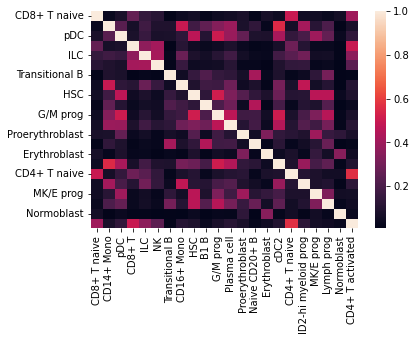

In [19]:
sns.heatmap(sim)

In [20]:
sim.shape

(22, 22)

In [21]:
# save
sim.to_csv('/gpfs/gibbs/pi/zhao/yw599/Multiome/data/BMMC/sim_BMMC.csv')